In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import preprocessing
import plotly.plotly as py
py.sign_in('wgopar', 'y3jt1ddvvu')
import plotly.graph_objs as go
%matplotlib inline

In [3]:
def preprocess(filename):
    """Preprocess NCDC weather data"""

    fields = ['STN', 'WBAN', 'YEARMODA', 'TEMP', 'TEMP_count', 'DEWP', 'DEWP_count', 'SLP', 'SLP_count', 'STP', 'STP_count', 'VISIB', 'VISIB_count', 'WDSP', 'WDSP_count', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP', 'FRSHTT']
     
    df = pd.read_csv(filename, 
                  sep=r'\s+', 
                  names=fields, 
                  header=0, 
                  parse_dates=['YEARMODA'], 
                  na_values={'TEMP':[9999.9], 
                             'DEWP':[9999.9], 
                             'SLP':[9999.9], 
                             'STP':[9999.9], 
                             'VISIB':[999.9], 
                             'WDSP':[999.9], 
                             'MXSPD':[999.9], 
                             'GUST':[999.9], 
                             'MAX':['9999.9'], # doesn't matter whether float or str
                             'MIN':['9999.9'], 
                             'PRCP':['99.99'],
                             'SNDP':[999.9]}
                 )
    flagged = df.copy()
 
    def strip_flag(x):
        if type(x) is float:
            return x
        elif type(x) is str:
            return float(x[:-1]) if '*' in x else float(x)
    def extract_flag(x):
        if type(x) is float:
            return False
        elif type(x) is str:
            return True if '*' in x else False
     
    flagged['MAX'] = df['MAX'].map(strip_flag)
    flagged['MAX_flag'] = df['MAX'].map(extract_flag)
    flagged['MIN'] = df['MIN'].map(strip_flag)
    flagged['MIN_flag'] = df['MIN'].map(extract_flag)
     
    flagged['PRCP'] = df['PRCP'].map(lambda x: float(x[:-1]) if type(x) is str else x)
    PRCP_flag = df['PRCP'].map(lambda x: x[-1] if type(x) is str else x)
    PRCP_dummies = pd.get_dummies(PRCP_flag).add_prefix('PRCP_')
    preprocessed = flagged.join(PRCP_dummies)
     
    return preprocessed

In [4]:
""" Take Nov. 81'-14' """
print ("processing 1...")
df1 = preprocess('CA_1981-1985.txt')
print ("processing 2...")
df2 = preprocess('CA_1985-1989.txt')
print ("processing 3...")
df3 = preprocess('CA_1989-1993.txt')
print ("processing 4...")
df4 = preprocess('CA_1993-1997.txt')
print ("processing 5...")
df5 = preprocess('CA_1997-2001.txt')
print ("processing 6...")
df6 = preprocess('CA_2001-2005.txt')
print ("processing 7...")
df7 = preprocess('CA_2005-2009.txt')
print ("processing 8...")
df8 = preprocess('CA_2009-2014.txt')

processing 1...
processing 2...
processing 3...
processing 4...
processing 5...
processing 6...
processing 7...
processing 8...


In [118]:
""" combine all data frames but just keep temp and prcp """
frames = [df1, df2, df3, df4, df5, df6, df7, df8]
df = pd.concat(frames)

df_processed = df[['STN','YEARMODA', 'TEMP', 'PRCP', 'GUST']].dropna(axis=0)
df_processed = df_processed.set_index('YEARMODA')

def subset(df):
    df[['TEMP','PRCP','GUST']] = preprocessing.scale(df[['TEMP','PRCP','GUST']].values) # normalize values w/r to station
    df_processed = df.resample('M')
    return df_processed[df_processed.index.month == 1]

df_processed = df_processed.groupby('STN').apply(subset)
df_processed = df_processed.dropna(axis=0)

""" re-processing  """
df_processed['label'] = df_processed.index # create label column with station and date info
df_processed.index = df_processed.index.droplevel(1) # drop the 'YEARMODA' index
df_processed = df_processed.set_index('label') # set the label as the index
df_processed = df_processed.ix[:-1] # drop the last row ( 999999 station)
print df_processed.head()
print df_processed.shape
""" saved the normed data """
data_normed = df_processed[['TEMP','PRCP','GUST']].values

                                  STN      TEMP      PRCP      GUST
label                                                              
(690020, 1990-01-31 00:00:00)  690020 -0.235794  0.800060 -0.361424
(690020, 1991-01-31 00:00:00)  690020 -0.492789 -0.235327 -1.312196
(690020, 1993-01-31 00:00:00)  690020 -0.804854 -0.235327  0.881893
(690020, 1995-01-31 00:00:00)  690020 -1.006779  1.860803  1.689875
(690020, 1996-01-31 00:00:00)  690020 -1.120591  0.291242  0.811195
(2770, 4)


In [119]:
print df_processed.shape

(2770, 4)


In [120]:
pca1 = PCA(n_components=2)
transformed1 = pca1.fit_transform(data_normed)

trace0 = go.Scatter(x=transformed1[:,0],
                    y=transformed1[:,1],
                    mode='markers',
                    marker= dict(color = 'rgba(152, 0, 0, .8)'),
                    text=df_processed.index
                    )
data = [trace0]
py.iplot(data,filename='simple-scatter')

In [121]:
""" 3d scatter of original data """


trace1= go.Scatter3d(x=data_normed[:,0],
                    y=data_normed[:,1],
                    z=data_normed[:,2],
                    mode='markers',
                    marker = dict(color = 'rgba(152, 0, 0, .8)',size=3),
                    text=df_processed.index
                    )

data = [trace1]
py.iplot(data,filename='simple-3d-scatter')

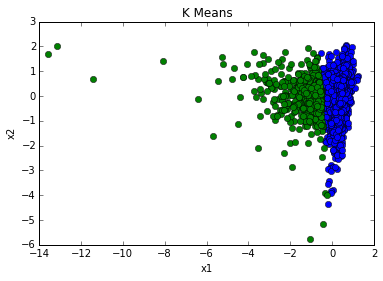

In [122]:
import scipy.cluster.vq as CL
import matplotlib.pyplot as pp

#number of centroids
numK = 2

centroids, sq = CL.kmeans(np.array(transformed1), numK)

#compute distance of each sample to the centroids
dist = [(np.sum((np.array(transformed1) - np.array([centroids[i]]))**2,1)) for i in range(numK)]

#assign sample to closest cluster
class_assigned = [(np.where(np.transpose(dist)[i]==min(np.transpose(dist)[i])))[0][0] for i in range(transformed1.shape[0])]
clustered = [[transformed1[i] for i, clu in enumerate(class_assigned) if clu == k*1.] for k in range(numK)]

# plotting each class
for k in range(numK):
    pp.plot(np.transpose(clustered[k])[0], np.transpose(clustered[k])[1],'o')

#### CHANGE THESE LABELS TO MATCH YOUR DATA
pp.title('K Means')
pp.xlabel('x1')
pp.ylabel('x2')
pp.show()

In [16]:
""" Clustered Points """
cluster0 = np.array(clustered[0])
cluster1 = np.array(clustered[1])
cluster2 = np.array(clustered[2])